In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee

np.random.seed(123)

# import matplotlib
# from matplotlib import rc;rc('text', usetex=True);rc('font', weight='bold');matplotlib.rcParams['text.latex.preamble'] = r'\boldmath'
# matplotlib.rcParams["figure.facecolor"] = 'white'
# matplotlib.rcParams['figure.dpi'] = 150
# matplotlib.rcParams['font.family'] = 'Times new roman'

In [2]:
# Choose the "true" params
m_true = -0.9594
b_true = 4.294
# f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N)) # 50 numbers between 0 - 10, in order
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
# y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

Text(0, 0.5, 'y')

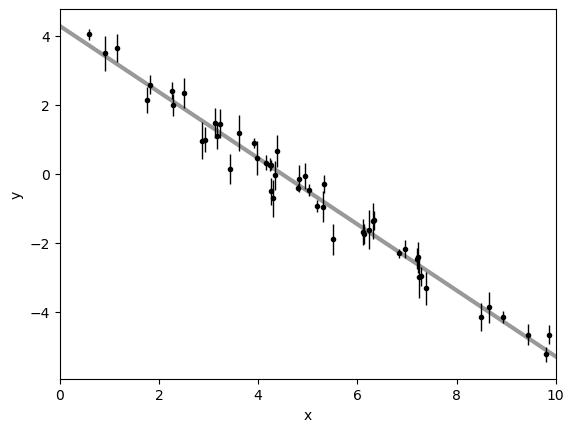

In [3]:
plt.errorbar(x, y, yerr = yerr, fmt = ".k", capsize = 0, lw = 1)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha = 0.4, lw = 3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")

In [4]:
# m-values to sample

m = np.arange(-5, 5, 0.01)
len(m)

1000

In [5]:
def chi2(theta, x, y, yerr):
    m, b = theta 
    model = m * x + b
    chi2 = np.sum((y - model)**2 / (yerr**2))
    return chi2

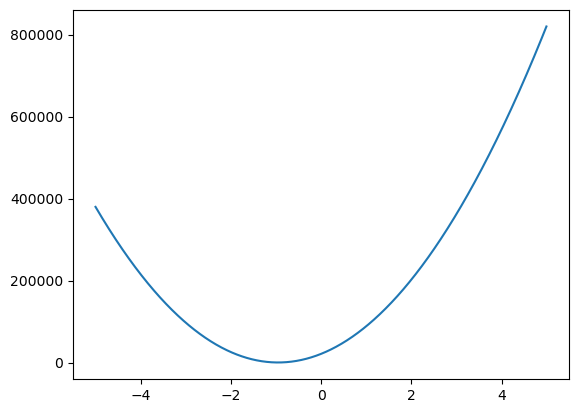

In [22]:
# find chi2 per m-value and plot w.r.t. m-value

chi_sq = np.array([chi2((slope, b_true), x, y, yerr) for slope in m])
plt.plot(m, chi_sq)

In [23]:
slope = m[np.argmin(chi_sq)]
print("\"True\" slope:", m_true)
print("Estimated slope:", slope)

"True" slope: -0.9594
Estimated slope: -0.9500000000000863


In [24]:
lnlike = -0.5 * chi_sq

In [25]:
lnlike = lnlike - max(lnlike) # lnlike now all neg values, like is between (0, 1]

delta_chisq= max(lnlike) - lnlike[0]
snr=np.sqrt(2 * delta_chisq)

L=np.exp(lnlike)
L/=max(L)
m_mode=m[np.argmax(L)]

In [26]:
def random_sampler(x, y, howmanysamples = 10000, burn_in = 500):
    import scipy.integrate as integrate
    import scipy.interpolate as interpolate

    norm = integrate.simps(y, x) #area under curve for norm
    y = y/norm

    cdf = np.asarray([integrate.simps(y[:i+1], x[:i+1]) for i in range(len(x))])
    cdf_inv = interpolate.interp1d(cdf, x)

    # sample x values for random cdf values between 0 and 1 
    random_sample = cdf_inv(np.random.rand(howmanysamples))

    return random_sample[burn_in:]  

def get_width_from_sampling(vals, likelihood_curve):
    randoms = random_sampler(vals, likelihood_curve)
    mean = vals[np.argmax(likelihood_curve)]
    low_err = mean - np.percentile(randoms, 16.)
    high_err = np.percentile(randoms, 84.) - mean

    return mean, low_err, high_err

In [27]:
from IPython.display import display, Math
estimate, low, high = get_width_from_sampling(m, L)
txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
txt = txt.format(estimate, low, high, "Slope")
display(Math(txt))

<IPython.core.display.Math object>

-------------------

# Ignore everything Below #

In [37]:
def get_lnlikelihood(data, model, cov):

    cov=np.mat(cov)
    cov_inv= np.squeeze(sc.linalg.pinv(cov))

    d=data.flatten()## - np.mean(MAP.flatten())
    m=model.flatten()## - np.mean(MODEL.flatten())
    d=d-m

    logLval= -0.5 * np.asarray( np.dot(d.T, np.dot( cov_inv, d ))).squeeze()

    return logLval

In [85]:
y_tile = np.tile(y, (len(m), 1))
yerr_tile = np.tile(yerr, (len(m), 1))
y_tile

array([[ 4.05604445,  3.49473158,  3.64659922, ..., -4.6674123 ,
        -5.23645677, -4.67072792],
       [ 4.05604445,  3.49473158,  3.64659922, ..., -4.6674123 ,
        -5.23645677, -4.67072792],
       [ 4.05604445,  3.49473158,  3.64659922, ..., -4.6674123 ,
        -5.23645677, -4.67072792],
       ...,
       [ 4.05604445,  3.49473158,  3.64659922, ..., -4.6674123 ,
        -5.23645677, -4.67072792],
       [ 4.05604445,  3.49473158,  3.64659922, ..., -4.6674123 ,
        -5.23645677, -4.67072792],
       [ 4.05604445,  3.49473158,  3.64659922, ..., -4.6674123 ,
        -5.23645677, -4.67072792]])

In [93]:
np.dot(y_tile - model, np.dot(yerr_tile.T, y_tile - model))

array([[  -81966.14923177,  -277205.68781996,  -223818.94553105, ...,
        -3109579.26933285, -3307442.99614367, -3110013.78893293],
       [  -81762.8299527 ,  -276518.07151577,  -223263.75650393, ...,
        -3101865.8727515 , -3299238.79316642, -3102299.31451381],
       [  -81559.51067362,  -275830.45521158,  -222708.56747681, ...,
        -3094152.47617014, -3291034.59018916, -3094584.84009467],
       ...,
       [  120743.17200726,   408347.76745693,   329704.51451028, ...,
         4580677.12227866,  4872147.37218343,  4581317.20693928],
       [  120946.49128634,   409035.38376112,   330259.70353741, ...,
         4588390.51886001,  4880351.57516069,  4589031.68135841],
       [  121149.81056541,   409723.0000653 ,   330814.89256453, ...,
         4596103.91544137,  4888555.77813795,  4596746.15577754]])

In [99]:
model[0]

array([  1.31010517,  -0.311247  ,  -1.48691975,  -4.47858781,
        -4.83058652,  -7.04857268,  -7.11916154,  -8.22876827,
       -10.01296675, -10.39170232, -11.31906115, -11.57027409,
       -11.85394569, -12.86490081, -13.79543278, -15.31187591,
       -15.60821277, -16.4473106 , -16.86132301, -16.99751451,
       -17.02356535, -17.24913817, -17.39105863, -17.63461223,
       -19.75259507, -19.85771321, -20.39025488, -20.79783379,
       -21.68025596, -22.28356869, -22.29737935, -23.27173845,
       -26.25717553, -26.35072629, -26.90364759, -27.25480619,
       -27.42604793, -29.94748693, -30.52945928, -31.67944849,
       -31.82816913, -31.92876624, -32.15848537, -32.60577029,
       -38.1775897 , -39.02145789, -40.37545816, -42.91400091,
       -44.74420992, -44.98398928])

In [100]:
np.dot((y - model[0]).T, np.dot(yerr.T, y - model[0]))

array([  957.87751327,  1327.65546729,  1790.74695277,  2308.29583308,
        2589.35802933,  3301.03617564,  3181.31536947,  3688.6636261 ,
        3829.69118667,  3970.95035856,  4458.84612742,  4420.15929993,
        4644.48116955,  4535.34420875,  5228.90046372,  5655.23498203,
        5606.29235781,  5849.61516631,  5976.02888103,  5751.21214002,
        6031.39879687,  5769.10489946,  6051.30727798,  6381.84941781,
        6751.01727083,  6877.81957726,  7092.16648423,  7090.83675252,
        7237.71475107,  7440.28245705,  7673.39781249,  7455.732368  ,
        8576.08578905,  8582.0307007 ,  8818.30912397,  9029.54454652,
        9098.27437322,  9641.19011639,  9888.24796849, 10193.05091329,
       10257.70656757, 10093.62072732, 10179.2502193 , 10217.3606187 ,
       11868.08814606, 12260.65403526, 12638.91781861, 13341.7178959 ,
       13781.65521343, 14062.64401755])

In [ ]:
def get_lnlikelihood(data, model, cov):
    
    

In [38]:
model.shape

(1000, 50)

In [49]:
model = np.array([slope * x + b_true for slope in m])
answers = np.array([get_lnlikelihood(y, model[i], yerr) for i in range(len(m))])

In [50]:
answers.shape

(1000, 50)

In [40]:
yerr.shape

(50,)

In [41]:
y.flatten().shape

(50,)